In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [7]:
with open('../expts/data/htpdata/solubility.pkl', 'rb') as handle:
    data = pickle.load(handle)
X_emb = np.load('../figures/notebooks/hte_tsne_Xembed.npy')


In [4]:
images_dir = '../figures/hteplots/*.png'
images_list = sorted([file for file in glob.glob(images_dir)])
print('Total of {} phase diagrams'.format(len(images_list)))

tagger = re.compile('../figures/hteplots/(.*)_(.*)_(.*).png')

tags_list = []
for img in images_list:
    tag = tagger.findall(img)
    tags_list.append(tag[0])
    
df_tags = pd.DataFrame(tags_list, columns=['solvent','small molecule','polymer'])

Total of 1720 phase diagrams


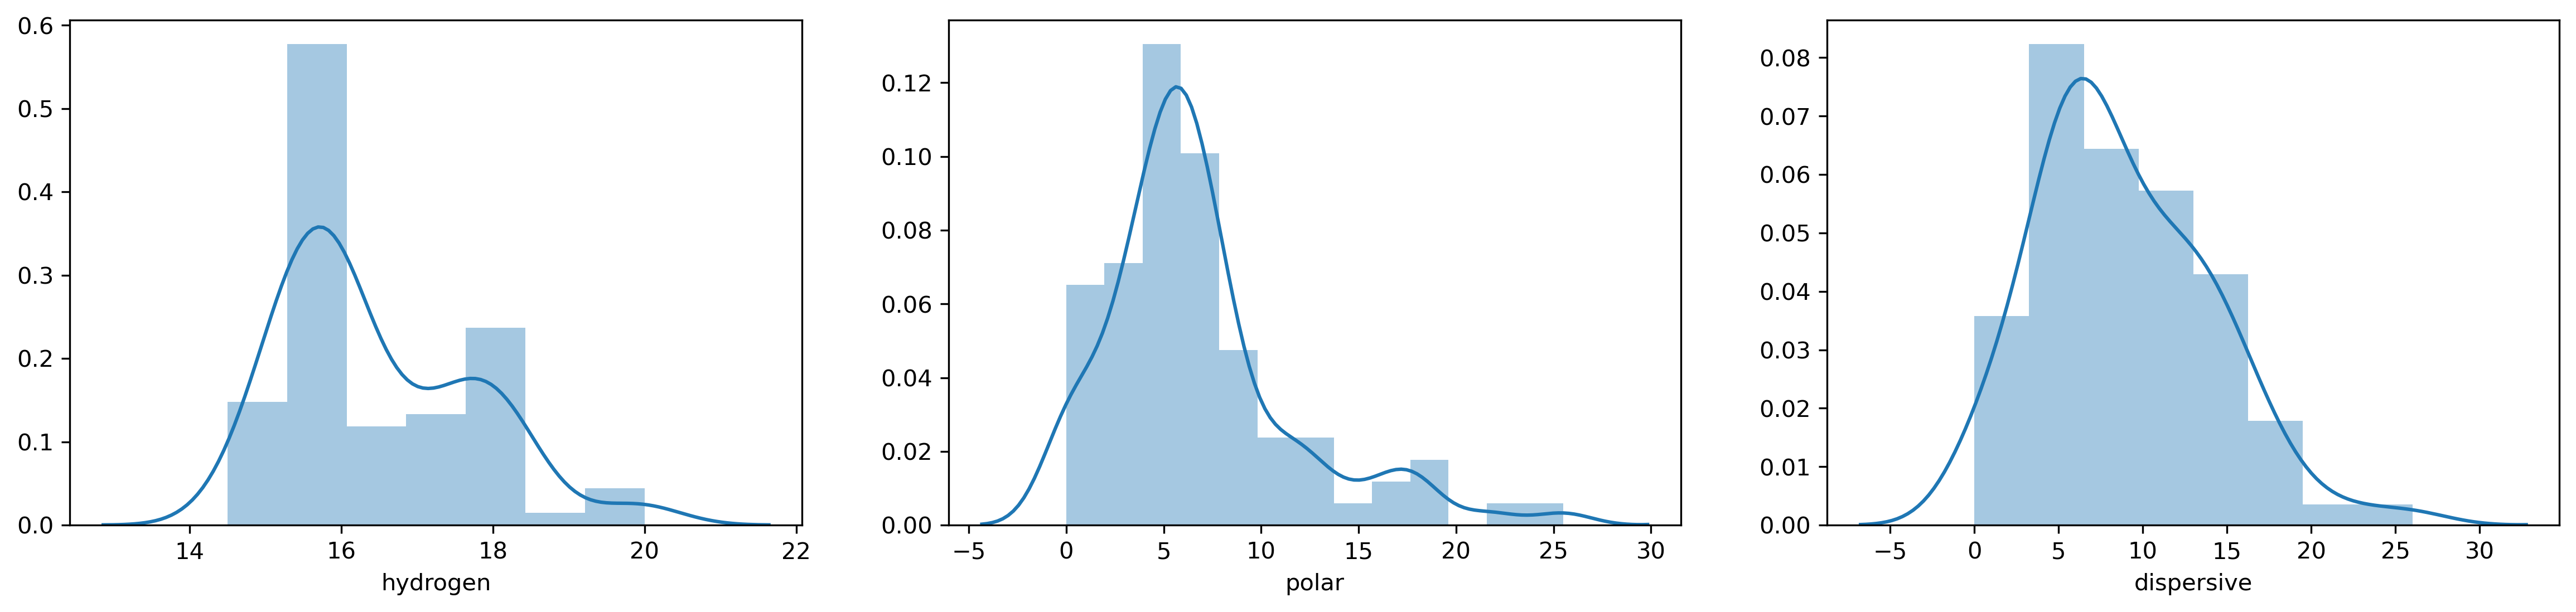

In [5]:
fig, axs = plt.subplots(1,3, figsize=(4*3*1.6, 4), dpi=300)
sns.distplot(data['solvents'].hydrogen, ax=axs[0])
sns.distplot(data['solvents'].polar, ax=axs[1])
sns.distplot(data['solvents'].dispersive, ax=axs[2])
plt.show()

In [8]:
df_tags['solv_h'] = df_tags['solvent'].apply(lambda x: data['solvents'].hydrogen[int(x)])
df_tags['solv_p'] = df_tags['solvent'].apply(lambda x: data['solvents'].polar[int(x)])
df_tags['solv_d'] = df_tags['solvent'].apply(lambda x: data['solvents'].dispersive[int(x)])
df_tags['tsne_x'] = X_emb[:,0]
df_tags['tsne_y'] = X_emb[:,1]
df_tags.head()

,solvent,small molecule,polymer,solv_h,solv_p,solv_d,tsne_x,tsne_y
0,0,DPP(PhTT)2,MDMO-PPV,15.5,10.4,7.0,-4.985990,11.262541
1,0,DPP(PhTT)2,MEH-PPV,15.5,10.4,7.0,-5.583282,11.735955
2,0,DPP(PhTT)2,P3HT,15.5,10.4,7.0,10.361498,25.491325
3,0,DPP(PhTT)2,PFO,15.5,10.4,7.0,-35.315708,-0.613992
4,0,DPP(TBFu)2,MDMO-PPV,15.5,10.4,7.0,-11.915854,4.606750


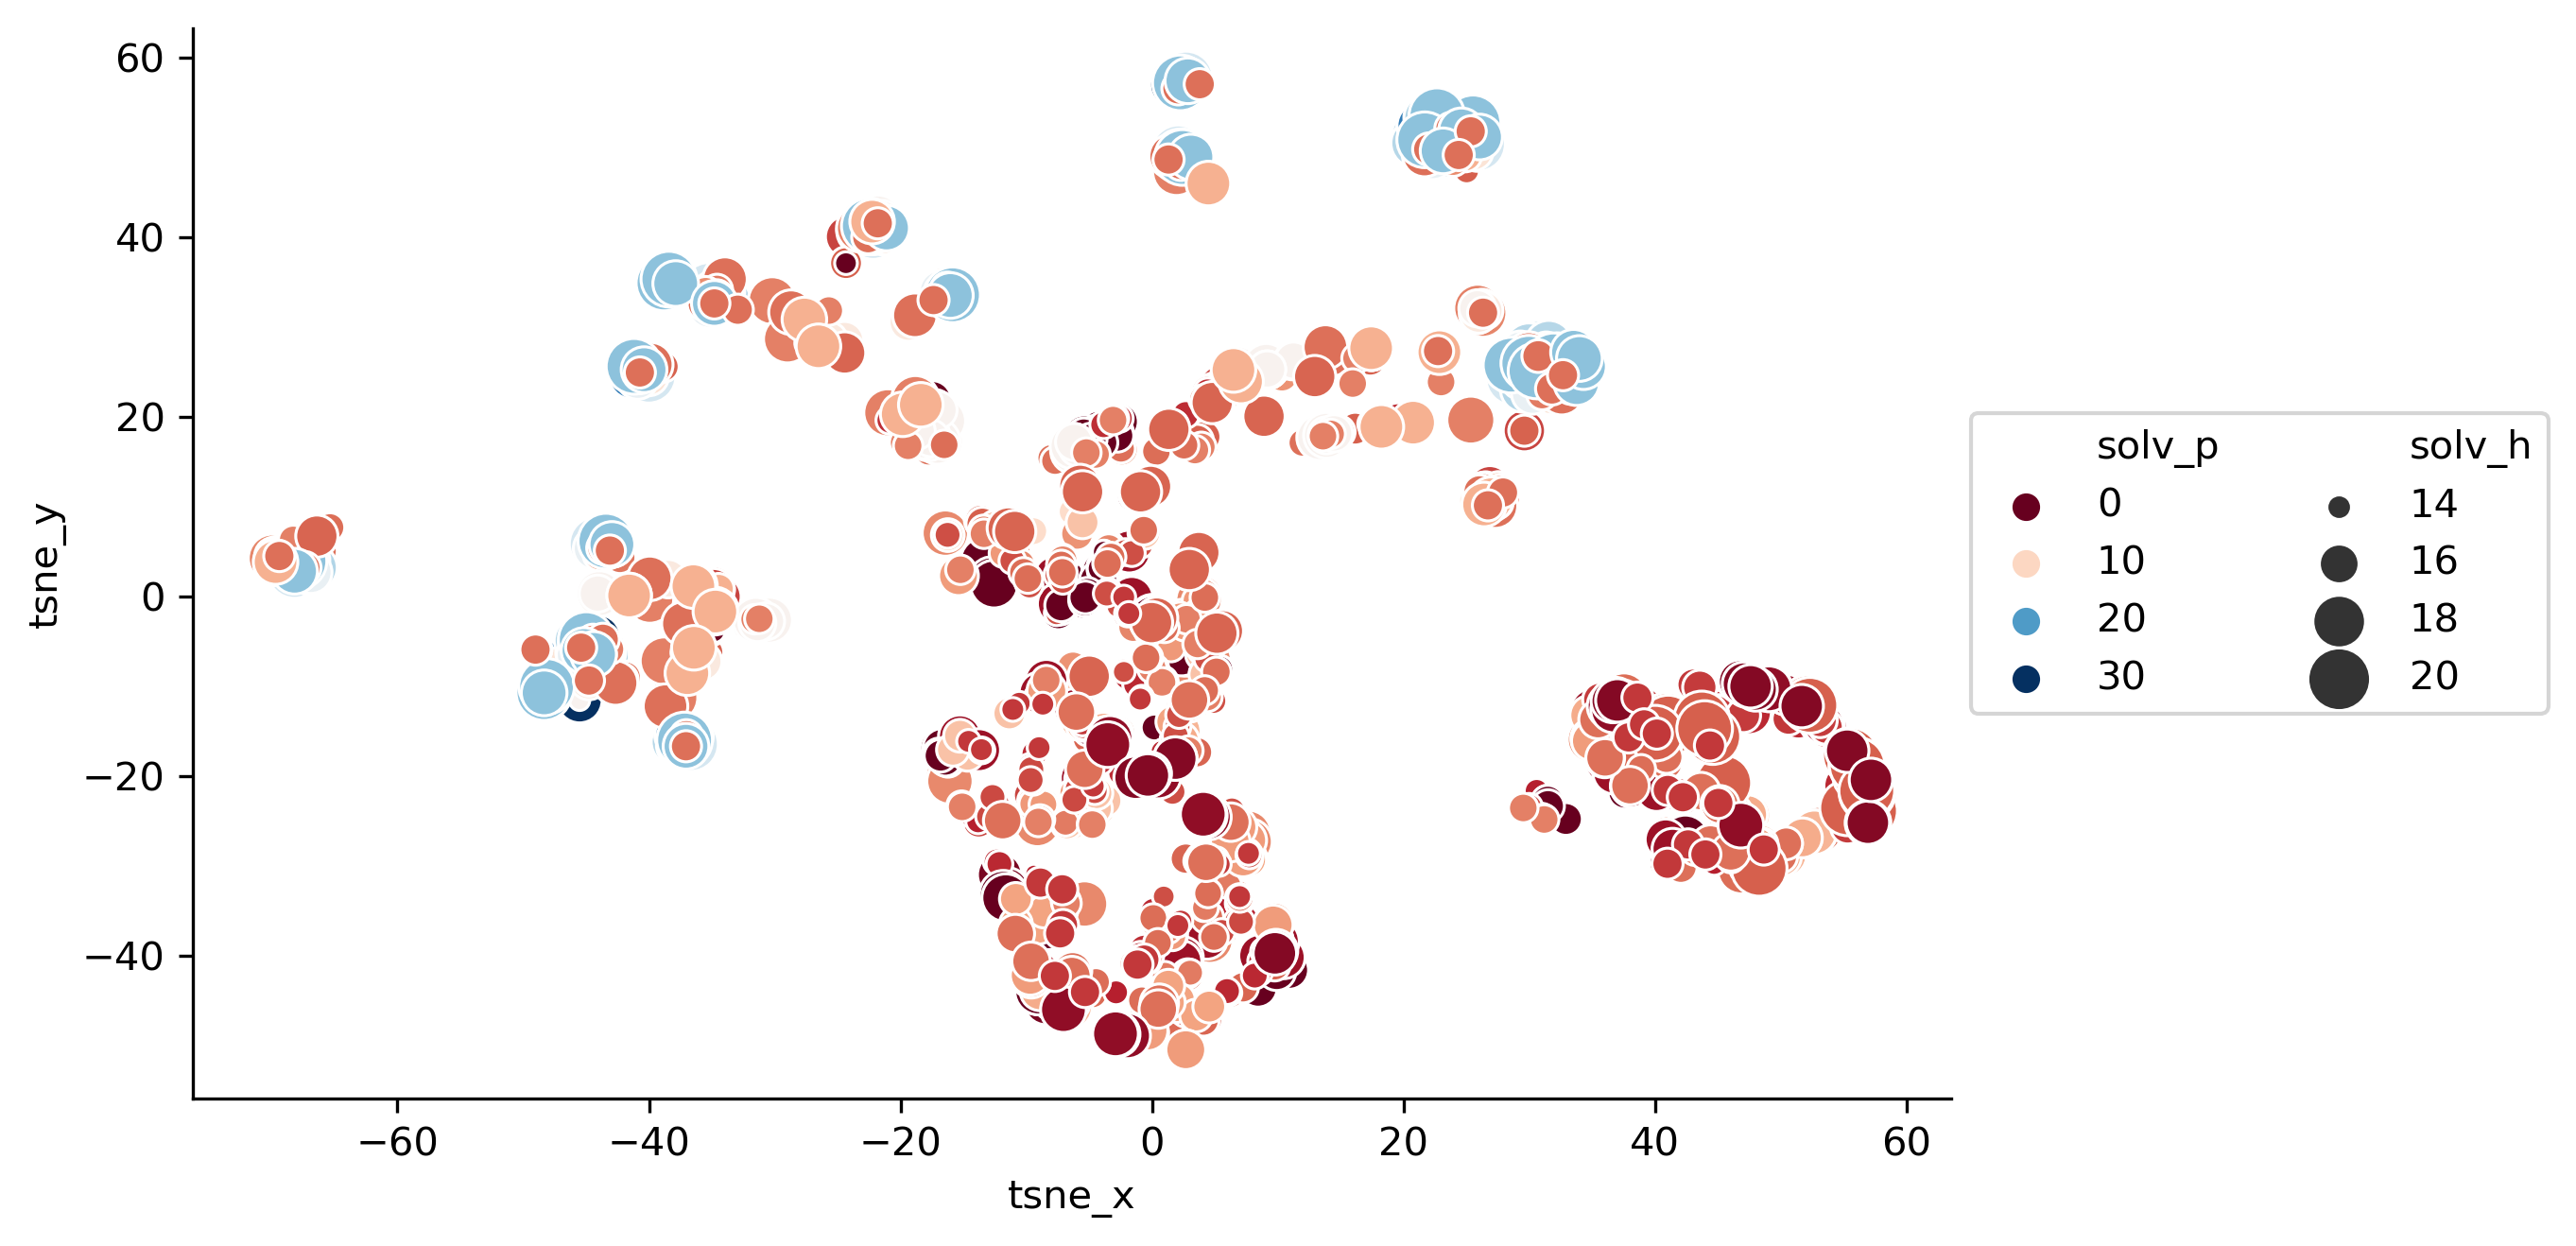

In [24]:
# look at how the tsne plot embeds the solubility parameters of solvent
fig, ax = plt.subplots(figsize=(5*1.6, 5),dpi=300)
ax = sns.scatterplot(x='tsne_x', y= 'tsne_y', size='solv_h', hue='solv_p',
                     sizes=(20, 200), data=df_tags, ax=ax, palette="RdBu"
)
sns.despine()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.show()

It appears that solvents with `polar` component >20 are placed closer than to solvents with ~(0-5). Most of the solvents have `hydrophobic` component near ~(16-18) and are generally spread across and does not show any interesting trends.
`dispersive` component also shows similar behavior : everything below 20 is seperated more or less